# Ethiopia Monsoon Onset Analysis Tutorial

This tutorial demonstrates a step-by-step analysis of monsoon onset dates using satellite precipitation data (CHIRPS) over Ethiopia.

## Workflow:

1. **Load data** and apply Kiremt seasonal mask
2. **Plot timeseries** for a selected point (before onset computation)
3. **Compute onset dates** using ICPAC definition
4. **Plot timeseries with onset markers** for the same point
5. **Compute median onset map** and statistics
6. **Calculate false onset percentage** (years where onset ≠ wet spell)
7. **Compute the interannual variability of onset dates**

## ICPAC Onset Definition:

**Onset occurs when:**
- Total rainfall in 3 consecutive days exceeds 20 mm
- Each day in the 3-day window must be "non-dry" (≥1mm)
- No dry spell of 7+ days occurs within the next 21 days

---

## Step 1: Setup and Import Libraries

In [25]:
# !pip install dask
# !pip install h5netcdf h5py

In [2]:
# Import required libraries
import h5netcdf, h5py
import subprocess
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import shapely.vectorized as shpvec
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import glob
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.dates as mdates

print("✓ All required libraries imported successfully!")

✓ All required libraries imported successfully!


## Step 2: Load CHIRPS Precipitation Data

Loading daily precipitation data at 0.25° resolution for Ethiopia region.

In [10]:
# Load CHIRPS precipitation data
# This dataset contains daily precipitation at 0.25° resolution
IMERG_CHIRPS = xr.open_mfdataset(
    "/Users/bodong/Code/benchmarking/data/CHIRPS_IMERG/*.nc", 
    chunks={}, 
    parallel=True, 
    engine="h5netcdf"
).sel(lat=slice(3, 15), lon=slice(33, 48))  # Focus on Ethiopia region

# Set up the dataset
ds = IMERG_CHIRPS

print(f"Dataset loaded successfully!")
print(f"Spatial extent: {ds.lat.min().values:.1f}°E to {ds.lon.max().values:.1f}°E, "
      f"{ds.lat.min().values:.1f}°N to {ds.lat.max().values:.1f}°N")
print(f"Time range: {pd.to_datetime(ds.TIME.min().values).strftime('%Y-%m-%d')} to "
      f"{pd.to_datetime(ds.TIME.max().values).strftime('%Y-%m-%d')}")

Dataset loaded successfully!
Spatial extent: 3.0°E to 48.0°E, 3.0°N to 15.0°N
Time range: 1998-01-01 to 2024-12-31


In [18]:
# Examine the dataset structure
from momp.utils.standard import dim_fmt, dim_fmt_model, dim_fmt_model_ensemble
from momp.lib.loader import get_cfg
cfg = get_cfg()

package base dir ~/Code/benchmarking/momp
Configuration validated!


In [13]:
ds = dim_fmt(ds)

In [22]:
mask_dir = os.path.join(cfg.obs_dir, '../../demo/data/')

aifs                       ngcm
ifs                        obs
jjas_seasonal_mask_0p25.nc shpfile
mwset4x4.nc4


## Step 3: Filter for Rainy Season Months

Focus on May-September (rainy season months) for the analysis period.

In [14]:
# Filter data for the analysis period and rainy season months
print("Filtering data for analysis period (1998-2024) and rainy season months (May-September)...")

# Select time period and rainy season months
ds_season = ds.sel(time=slice("1998-01-01", "2024-12-31"))  # Analysis period
ds_season = ds_season.sel(time=ds_season["time"].dt.month.isin([5,6,7,8,9]))  # May-September

print(f"✓ Filtered to {len(ds_season.time)} days across {ds_season.time.dt.year.max().values - ds_season.time.dt.year.min().values + 1} years")

Filtering data for analysis period (1998-2024) and rainy season months (May-September)...
✓ Filtered to 4131 days across 27 years


In [50]:
# Set precipitation variable name
PVAR = "RAINFALL"  # Variable name in the dataset

# Extract daily precipitation data
pr = ds_season[PVAR]
print(f"Precipitation data shape: {pr.shape}")
print(f"Loading data into memory...")
pr = pr.load()
print("✓ Data loaded successfully!")

pr = dim_fmt(pr)

Precipitation data shape: (4131, 49, 61)
Loading data into memory...
✓ Data loaded successfully!


In [47]:
# MASKING THE DATA TO ETHIOPIA BOUNDARIES
# Load Ethiopia shapefile
ethiopia_shp = shpreader.natural_earth(resolution='10m', category='cultural', 
                                       name='admin_0_countries')

# Find Ethiopia geometry
ethiopia_geom = None
for country in shpreader.Reader(ethiopia_shp).records():
    if country.attributes['NAME'] == 'Ethiopia':
        ethiopia_geom = country.geometry
        break

if ethiopia_geom is None:
    raise RuntimeError("Ethiopia geometry not found in natural_earth dataset.")
else:
    print("✓ Ethiopia geometry loaded from natural_earth")

# Load precomputed JJAS seasonal mask 
mask_file = os.path.join(mask_dir, "jjas_seasonal_mask_0p25.nc")
print(f"\n📁 Loading precomputed JJAS mask from: {mask_file}")

# Open file (handle either DataArray or Dataset)
ds_mask_file = xr.open_dataset(mask_file) if mask_file.endswith(".nc") else xr.open_dataarray(mask_file)

# Pick the DataArray if a Dataset was returned
if isinstance(ds_mask_file, xr.Dataset):
    varname = list(ds_mask_file.data_vars)[0]
    jjas_loaded = ds_mask_file[varname]
    print(f"  • Dataset contains variable: '{varname}' -> using that as JJAS mask")
else:
    jjas_loaded = ds_mask_file
    print(f"  • Loaded DataArray as JJAS mask")

# # Ensure dims are named latitude/longitude to match our data
# rename_map = {}
# dims = list(jjas_loaded.dims)
# if 'lat' in dims and 'latitude' not in dims:
#     rename_map['lat'] = 'latitude'
# if 'lon' in dims and 'longitude' not in dims:
#     rename_map['lon'] = 'longitude'
# if 'y' in dims and 'latitude' not in dims:
#     rename_map['y'] = 'latitude'
# if 'x' in dims and 'longitude' not in dims:
#     rename_map['x'] = 'longitude'
# if rename_map:
#     jjas_loaded = jjas_loaded.rename(rename_map)

# # Align mask coordinates to dataset grid if needed (nearest)
# # This will avoid dimension mismatches if small coordinate differences exist
# try:
jjas_mask = jjas_loaded.sel(latitude=ds.lat, longitude=ds.lon, method="nearest")
# except Exception:
#     # fallback: try transposing / reordering dims
#     jjas_mask = jjas_loaded.transpose('latitude', 'longitude')

# Ensure boolean mask
jjas_mask = jjas_mask.astype(bool)
# Step 1: rename to temporary unique names
print("dims:", jjas_mask.dims)
print("coords:", list(jjas_mask.coords))

# 1) move the existing latitude/longitude coords to safe names
jj = jjas_mask.rename({"latitude": "latitude_aux", "longitude": "longitude_aux"})
# 2) now rename the actual dims/coords lat/lon to latitude/longitude
jj = jj.rename({"lat": "latitude", "lon": "longitude"})
jjas_mask = jj
# jjas_mask = jjas_mask.rename({"lat": "latitude", "lon": "longitude"})


print(f"  • JJAS mask shape: {jjas_mask.shape}, dims: {jjas_mask.dims}")

# Create Ethiopia polygon mask (boolean) on the same grid
# Build lon/lat mesh matching the mask coordinates
lons, lats = np.meshgrid(jjas_mask.longitude.values, jjas_mask.latitude.values)
points = np.column_stack((lons.ravel(), lats.ravel()))
eth_mask_flat = shpvec.contains(ethiopia_geom, points[:, 0], points[:, 1])
eth_mask = eth_mask_flat.reshape(lons.shape)
# eth_mask.rename({'latitude':'lat', 'longitude':'lon'})

# Create an xarray DataArray for the Ethiopia mask and also provide a short name 'mask'
mask = xr.DataArray(eth_mask, dims=['latitude', 'longitude'],
                    coords={'latitude': jjas_mask.latitude, 'longitude': jjas_mask.longitude})
eth_mask = mask  # keep both names for compatibility with later cells

# Combine JJAS and Ethiopia masks
jjas_mask_ethiopia = jjas_mask.where(mask)

print(f"\n✓ Seasonal masks loaded and combined:")
print(f"   • Total grid points in domain: {jjas_mask.size}")
print(f"   • Kiremt season points in Ethiopia: {int(jjas_mask_ethiopia.sum(skipna=True).values)}")

✓ Ethiopia geometry loaded from natural_earth

📁 Loading precomputed JJAS mask from: ../data/CHIRPS_IMERG/../../demo/data/jjas_seasonal_mask_0p25.nc
  • Dataset contains variable: 'precip' -> using that as JJAS mask
dims: ('lat', 'lon')
coords: ['longitude', 'latitude', 'lat', 'lon']
  • JJAS mask shape: (49, 61), dims: ('latitude', 'longitude')

✓ Seasonal masks loaded and combined:
   • Total grid points in domain: 2989
   • Kiremt season points in Ethiopia: 821


/var/folders/w6/l8h49t45453f312k9_v1yv5w0000gn/T/ipykernel_79896/143362253.py:76: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  eth_mask_flat = shpvec.contains(ethiopia_geom, points[:, 0], points[:, 1])


## Step 5: Plot Rainfall Timeseries for Selected Point (Before Onset Computation)

Select a grid point and visualize its rainfall pattern.

Selected location: 10.0°N, 40.0°E
Selected year: 2020


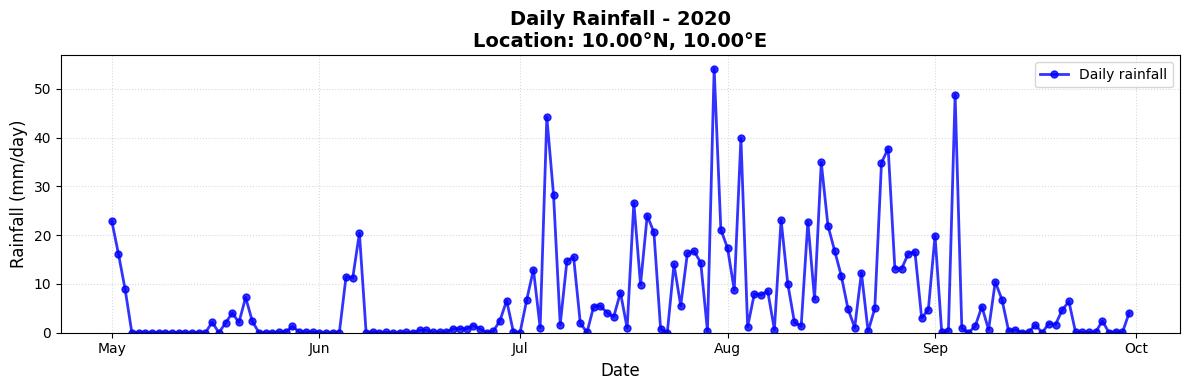

✓ Timeseries plotted for 10.00°N, 10.00°E


In [53]:
# User-selected point
lat_select = 10.0   # Change this to your desired latitude
lon_select = 40.0   # Change this to your desired longitude
year_select = 2020  # Change this to your desired year

print(f"Selected location: {lat_select}°N, {lon_select}°E")
print(f"Selected year: {year_select}")

# Select the nearest grid point
pr_point = pr.sel(lat=lat_select, lon=lon_select, method="nearest")
actual_lat = float(pr_point.lat.values)
actual_lon = float(pr_point.lat.values)

# Filter for selected year
pr_year = pr_point.sel(time=pr_point.time.dt.year == year_select)

# Plot rainfall timeseries
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(pr_year.time, pr_year.values, marker='o', markersize=5, linewidth=2,
        color='blue', markerfacecolor='blue', alpha=0.8, label='Daily rainfall')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rainfall (mm/day)', fontsize=12)
ax.set_title(f'Daily Rainfall - {year_select}\nLocation: {actual_lat:.2f}°N, {actual_lon:.2f}°E', 
            fontsize=14, fontweight='bold')

ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', color='gray')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print(f"✓ Timeseries plotted for {actual_lat:.2f}°N, {actual_lon:.2f}°E")

---

## Step 6: Define ICPAC Onset Computation Function

This function implements the ICPAC onset definition with optional dry spell criterion.

In [54]:
def compute_onset_dates(
    pr,
    search_start_date="05-15",   # MM-DD format: date from which to start onset search
    non_dry_thresh=1.0,          # mm/day: "non-dry" day threshold
    wet_window_days=3,           # days in wet spell window
    wet_window_rain=20.0,        # mm in wet_window_days: wet spell threshold
    dry_spell_days=7,            # length of dry spell after onset (if used)
    dry_spell_thresh=1.0,        # mm/day threshold for dry spell
    dry_spell_search_days=21,    # search window for dry spell after onset
    use_dry_spell=False           # flag: whether to enforce dry spell criterion
):
    """
    Compute onset dates per year and grid point using ICPAC definition.
    Onset defined as the first day of a wet spell if the total rainfall 
    accumulation within 3 consecutive days exceeds 20 mm and there is no 
    dry spell of 7 or more days within the next 21 days.
    """
    
    def onset_1d(pr_1d, time_1d):
        """Compute onset date for one grid cell and one year."""
        p = pr_1d
        t = pd.to_datetime(time_1d)
        n = len(p)
        
        # Compute LEFT-ALIGNED rolling sum for this year only
        # This makes the rolling sum at position i include values from i, i+1, i+2
        r = pd.Series(p).rolling(window=wet_window_days, min_periods=wet_window_days).sum().shift(-(wet_window_days-1)).values
        
        # Find the index corresponding to the search start date
        year = t[0].year
        search_start = pd.to_datetime(f"{year}-{search_start_date}")
        
        # Find first index on or after search_start_date
        start_idx = 0
        for idx, date in enumerate(t):
            if date >= search_start:
                start_idx = idx
                break
        else:
            # If search_start_date is after all dates in the year, return NaT
            return pd.NaT

        for i in range(start_idx, n - wet_window_days + 1):  # Adjust range for left-aligned window
            # check wet spell window (starting at i)
            if np.isnan(r[i]) or r[i] < wet_window_rain:
                continue

            # also require that each day in window is non-dry
            window_p = p[i:i+wet_window_days]
            if np.any(np.isnan(window_p)) or np.any(window_p < non_dry_thresh):
                continue

            onset_idx = i  # onset date = first day of wet spell (since left-aligned)
            
            # Check if the onset date is on or after the search start date
            if t[onset_idx] < search_start:
                continue  # Skip this candidate if onset is before search start date

            if not use_dry_spell:
                return t[onset_idx]

            # if using dry spell criterion: search only within next 21 days
            search_end = min(onset_idx + dry_spell_search_days, n)
            
            # Check for dry spell of 7+ days within the next 21 days
            dry_spell_found = False
            for j in range(onset_idx, search_end - dry_spell_days + 1):
                if j + dry_spell_days <= n:
                    segment = p[j:j+dry_spell_days]
                    if np.all(segment < dry_spell_thresh):
                        # found a dry spell within 21 days; reject this candidate
                        dry_spell_found = True
                        break
            
            if not dry_spell_found:
                # No dry spell found within 21 days - valid onset
                return t[onset_idx]

        return pd.NaT

    # Process each year separately to avoid rolling sum contamination
    onset_date_list = []
    
    for y, pr_y in pr.groupby("time.year"):
        print(f"Processing year {y}...")
        
        # Extract time for this year
        time_y = pr_y["time"]
        
        # Apply the onset calculation for this year only
        onset_y = xr.apply_ufunc(
            onset_1d,
            pr_y,
            time_y,
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[[]],
            vectorize=True,
            dask="forbidden",  # Avoid casting issues
            output_dtypes=[object],  # Use object to handle pandas timestamps
        ).assign_coords(year=y)

        onset_date_list.append(onset_y)

    # Combine results from all years
    onset_date = xr.concat(onset_date_list, dim="year")
    onset_date.name = "onset_date"
    return onset_date

## Step 7: Compute Onset Dates for All Grid Points

Computing onset dates using ICPAC definition (with dry spell criterion) and wet spell dates (without dry spell criterion).

In [55]:
# Compute onset dates using the full ICPAC definition (with dry spell criterion)
print("=" * 60)
print("COMPUTING ONSET DATES (with dry spell criterion)")
print("=" * 60)

onset_date = compute_onset_dates(
    pr,
    search_start_date="05-15",   # Start searching from May 15
    non_dry_thresh=1.0,          # Non-dry day threshold: 1mm
    wet_window_days=3,           # 3-day wet spell window
    wet_window_rain=20.0,        # 20mm total in 3 days
    dry_spell_days=7,            # 7-day dry spell length
    dry_spell_thresh=1.0,        # <1mm/day for dry spell
    dry_spell_search_days=21,    # Check for dry spells in next 21 days
    use_dry_spell=True          # Enable dry spell criterion
)

# Compute wet spell dates WITHOUT dry spell criterion
print("\n" + "=" * 60)
print("COMPUTING WET SPELL DATES (without dry spell criterion)")
print("=" * 60)

wetspell_date = compute_onset_dates(
    pr,
    search_start_date="05-15",
    non_dry_thresh=1.0,
    wet_window_days=3,
    wet_window_rain=20.0,
    dry_spell_days=7,
    dry_spell_thresh=1.0,
    dry_spell_search_days=21,
    use_dry_spell=False  # WITHOUT dry spell criterion
)

print("\n✓ Onset and wet spell dates computed successfully!")

COMPUTING ONSET DATES (with dry spell criterion)
Processing year 1998...
Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...
Processing year 2021...
Processing year 2022...
Processing year 2023...
Processing year 2024...

COMPUTING WET SPELL DATES (without dry spell criterion)
Processing year 1998...
Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Proces

### Basic Statistics and Day-of-Year Conversion

Let's examine the onset dates and convert them to day-of-year for easier analysis.

## Step 8: Plot Rainfall Timeseries with Onset and Wet Spell Markers

Plot the same grid point's rainfall with vertical lines marking onset and wet spell dates.

📊 Onset Statistics:
   • Climatological mean onset: Day 178
   • Median onset: Day 177
   • Example location (10.0°N, 10.0°E): Day 174
Plotting timeseries with onset markers for: 10.00°N, 10.00°E, Year 2020


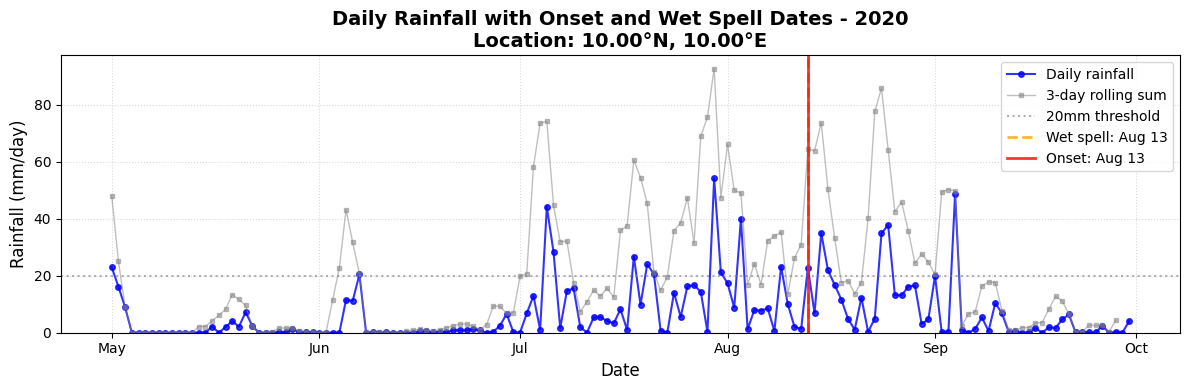

✓ Onset: Aug 13
✓ Wet spell: Aug 13


In [59]:
# Convert onset dates to day-of-year for easier statistical analysis
onset_doy = onset_date.dt.dayofyear
onset_clim_doy = onset_doy.mean(dim="year", skipna=True)  # Climatological mean
onset_median_doy = onset_doy.median(dim="year", skipna=True)  # Median

print("📊 Onset Statistics:")
print(f"   • Climatological mean onset: Day {onset_clim_doy.mean(skipna=True).values:.0f}")
print(f"   • Median onset: Day {onset_median_doy.mean(skipna=True).values:.0f}")

# Example: Check onset for a specific location
#example_lat, example_lon = 8, 36
example_onset = onset_clim_doy.sel(lon=actual_lon, lat=actual_lat, method="nearest")
print(f"   • Example location ({actual_lat}°N, {actual_lon}°E): Day {example_onset.values:.0f}")

# Convert to day-of-year for statistics (optional)
onset_doy = onset_date.dt.dayofyear
wetspell_doy = wetspell_date.dt.dayofyear

# Use the SAME point selected earlier
print(f"Plotting timeseries with onset markers for: {actual_lat:.2f}°N, {actual_lon:.2f}°E, Year {year_select}")

# Select onset and wetspell for the same point
onset_point = onset_date.sel(lat=actual_lat, lon=actual_lon, method="nearest")
wetspell_point = wetspell_date.sel(lat=actual_lat, lon=actual_lon, method="nearest")

# Get onset and wetspell for selected year
onset_year = onset_point.sel(year=year_select)
wetspell_year = wetspell_point.sel(year=year_select)

# Compute 3-day rolling sum (left-aligned) for the selected year
rolling_sum_3d = pd.Series(pr_year.values).rolling(window=3, min_periods=3).sum().shift(-2).values

# Plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot daily rainfall
ax.plot(pr_year.time, pr_year.values, marker='o', markersize=4, linewidth=1.5,
        color='blue', markerfacecolor='blue', alpha=0.8, label='Daily rainfall')

# Plot 3-day rolling sum (left-aligned)
ax.plot(pr_year.time, rolling_sum_3d, marker='s', markersize=3, linewidth=1,
        color='grey', markerfacecolor='grey', alpha=0.5, label='3-day rolling sum')

# Add horizontal line at 20mm threshold
ax.axhline(y=20, color='gray', linewidth=1.5, linestyle=':', 
           label='20mm threshold', alpha=0.6)

# Mark wet spell date
if not pd.isna(wetspell_year.values):
    wetspell_datetime = pd.to_datetime(wetspell_year.values)
    ax.axvline(x=wetspell_datetime, color='orange', linewidth=2, linestyle='--', 
              label=f'Wet spell: {wetspell_datetime.strftime("%b %d")}', alpha=0.8)

# Mark onset date
if not pd.isna(onset_year.values):
    onset_datetime = pd.to_datetime(onset_year.values)
    ax.axvline(x=onset_datetime, color='red', linewidth=2, linestyle='-', 
              label=f'Onset: {onset_datetime.strftime("%b %d")}', alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rainfall (mm/day)', fontsize=12)
ax.set_title(f'Daily Rainfall with Onset and Wet Spell Dates - {year_select}\nLocation: {actual_lat:.2f}°N, {actual_lon:.2f}°E', 
            fontsize=14, fontweight='bold')

ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', color='gray')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print(f"✓ Onset: {onset_datetime.strftime('%b %d') if not pd.isna(onset_year.values) else 'N/A'}")
print(f"✓ Wet spell: {wetspell_datetime.strftime('%b %d') if not pd.isna(wetspell_year.values) else 'N/A'}")

---

## Part 3: Geographic Masking and Seasonal Classification

To focus our analysis on relevant regions, we'll create geographic and seasonal masks.

## Step 9: Compute Median Onset Date Map

Calculate the median onset date across all years for each grid point in the Kiremt region.

In [85]:

print(f"✓ Seasonal masks created:")
print(f"   • Total grid points in domain: {jjas_mask.size}")
print(f"   • Kiremt season points: {jjas_mask.sum().values}")
print(f"   • Kiremt coverage: {100*jjas_mask.sum().values/jjas_mask.size:.1f}%")

# Combine Ethiopia country mask with Kiremt seasonal mask
# jjas_mask_ethiopia = jjas_mask.where(
#     xr.DataArray(
#         mask, 
#         dims=['latitude', 'longitude'], 
#         coords={
#             'latitude': jjas_mask.latitude, 
#             'longitude': jjas_mask.longitude
#         }
#     )
# )
# print("dims:", jjas_mask.dims)
# print("coords:", list(jjas_mask.coords))
# print("dims:", mask.dims)
# print("coords:", list(mask.coords))

# ensure it's boolean (optional but recommended)
cond = mask.astype(bool) if hasattr(mask, "astype") else mask
jjas_mask_ethiopia = jjas_mask.where(cond)


# Apply Kiremt mask to onset data
# onset_doy_masked = onset_doy.where(
#     xr.DataArray(eth_mask, dims=['latitude', 'longitude'],
#                 coords={'latitude': onset_doy.latitude, 'longitude': onset_doy.longitude})
# )

cond = eth_mask.astype(bool) if hasattr(eth_mask, "astype") else eth_mask
onset_doy_masked = onset_doy.where(cond)

onset_doy_kiremt = onset_doy_masked.where(jjas_mask_ethiopia)

# Compute median onset date across all years
onset_median_doy = onset_doy_kiremt.median(dim="year", skipna=True)

print(f"✓ Median onset date computed")
print(f"  Mean median onset (DOY): {onset_median_doy.mean(skipna=True).values:.1f}")
print(f"  Min median onset (DOY): {onset_median_doy.min(skipna=True).values:.1f}")
print(f"  Max median onset (DOY): {onset_median_doy.max(skipna=True).values:.1f}")

✓ Seasonal masks created:
   • Total grid points in domain: 2989
   • Kiremt season points: 1433
   • Kiremt coverage: 47.9%
✓ Median onset date computed
  Mean median onset (DOY): 176.9
  Min median onset (DOY): 135.0
  Max median onset (DOY): 272.0


### Visualizing the Kiremt Season Mask

Let's create a map showing where the Kiremt (JJAS) season dominates.

## Step 10: Plot Median Onset Date Map

Visualize the spatial pattern of median onset dates across Ethiopia's Kiremt region.

/Users/bodong/Code/benchmarking/.venv-momp/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:258: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


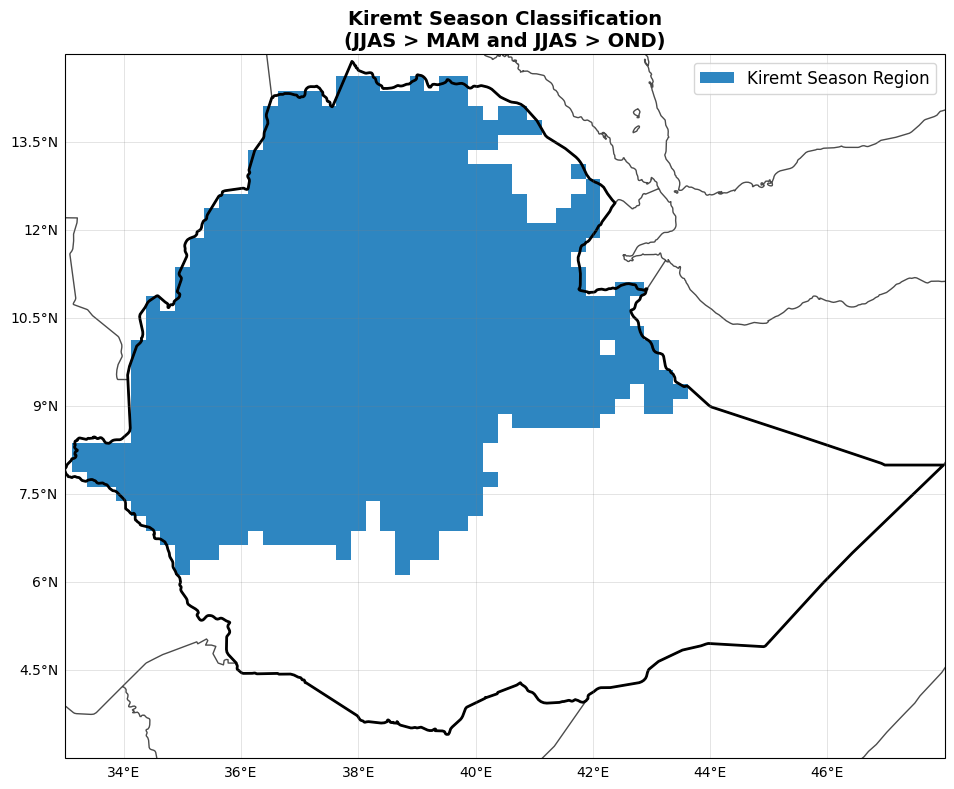

✓ Kiremt season covers 821.0 grid points
('lat', 'lon', 'latitude', 'longitude')
(49, 61, 49, 61)
XXXXX
('latitude', 'longitude')
(49, 61)


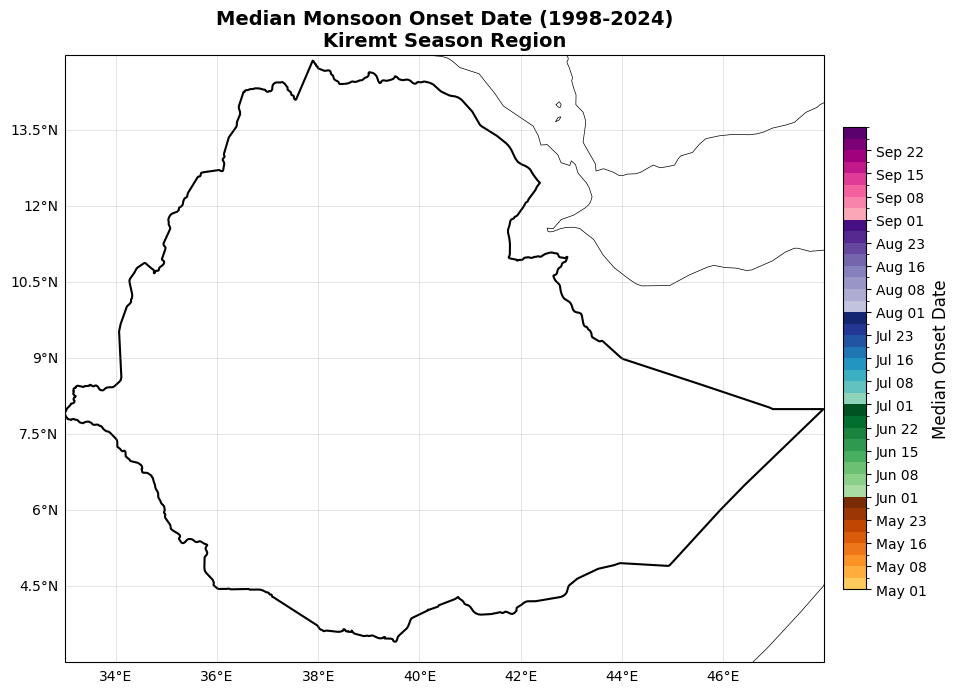

✓ Median onset map displayed


In [89]:
# Visualize the Kiremt season mask
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Create custom colormap for clear visualization
colors = ['white', '#2E86C1']  # White for non-Kiremt, blue for Kiremt
cmap = mcolors.ListedColormap(colors)

# Plot the mask
im = ax.pcolormesh(
    jjas_mask_ethiopia.longitude, 
    jjas_mask_ethiopia.latitude, 
    jjas_mask_ethiopia.astype(int), 
    cmap=cmap, 
    vmin=0, 
    vmax=1, 
    transform=ccrs.PlateCarree(), 
    shading='auto'
)

# Add geographic features
ax.add_geometries([ethiopia_geom], ccrs.PlateCarree(), 
                  facecolor='none', edgecolor='black', linewidth=2)
ax.add_feature(cfeature.COASTLINE, linewidth=1, alpha=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=1, alpha=0.7)

# Set extent and add gridlines
ax.set_extent([33, 48, 3, 15], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.3)
gl.top_labels = False
gl.right_labels = False

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86C1', label='Kiremt Season Region')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.title('Kiremt Season Classification\n(JJAS > MAM and JJAS > OND)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

print(f"✓ Kiremt season covers {jjas_mask_ethiopia.sum(skipna=True).values} grid points")

# Helper function to convert DOY to date string
def doy_to_mmm_dd(doy):
    """Convert day of year to 'MMM DD' format"""
    # Use 2018 (not a leap year) as reference to handle all possible DOYs
    date = pd.to_datetime(f"2018-{int(doy):03d}", format="%Y-%j")
    return date.strftime("%b %d")

# Create the custom monthly colormap (only until September)
from matplotlib.colors import ListedColormap, BoundaryNorm

month_cmaps = {
    "May":    plt.cm.YlOrBr,
    "Jun":    plt.cm.Greens,
    "Jul":    plt.cm.YlGnBu,
    "Aug":    plt.cm.Purples,
    "Sep":    plt.cm.RdPu,
}

# Day-of-year ranges (only until September)
month_doys = {
    "May": (121, 151),  # May 1 - May 31
    "Jun": (152, 181),  # Jun 1 - Jun 30
    "Jul": (182, 212),  # Jul 1 - Jul 31
    "Aug": (213, 243),  # Aug 1 - Aug 31
    "Sep": (244, 273),  # Sep 1 - Sep 30
}

colors = []
bounds = []

N_per_month = 8  # smoothness inside each month

for month, cmap in month_cmaps.items():
    d0, d1 = month_doys[month]
    
    # Sequential slice of each colormap
    ramp = cmap(np.linspace(0.35, 0.95, N_per_month))
    
    colors.extend(ramp)
    bounds.extend(np.linspace(d0, d1, N_per_month, endpoint=False))

# Add final bound
bounds.append(list(month_doys.values())[-1][1])

cmap_jjas = ListedColormap(colors, name="JJAS_piecewise")
norm_jjas = BoundaryNorm(bounds, cmap_jjas.N)

# Create the map
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

print(onset_median_doy.dims)
print(onset_median_doy.shape)
da2 = onset_median_doy.isel(lat=0, lon=0).drop_vars(["latitude", "longitude"], errors="ignore")


# Plot median onset with custom colormap
# im = ax.pcolormesh(onset_median_doy.lon, onset_median_doy.lat, onset_median_doy, 
#                    cmap=cmap_jjas, norm=norm_jjas, transform=ccrs.PlateCarree(), shading='auto')

print("XXXXX")
print(da2.dims)
print(da2.shape)
im = ax.pcolormesh(da2.longitude, da2.latitude, da2, 
                   cmap=cmap_jjas, norm=norm_jjas, transform=ccrs.PlateCarree(), shading='auto')

# Add Ethiopia boundary
ax.add_geometries([ethiopia_geom], ccrs.PlateCarree(), 
                  facecolor='none', edgecolor='black', linewidth=1.5)
ax.coastlines(resolution='50m', linewidth=0.5)

# Set extent
ax.set_extent([33, 48, 3, 15], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.3)
gl.top_labels = False
gl.right_labels = False

# Add colorbar with MMM DD labels for every other tick
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.6, aspect=20)

# Create tick positions - use every other bound for labeling
tick_positions = bounds[::2]  # Every other boundary
tick_labels = [doy_to_mmm_dd(doy) for doy in tick_positions[:-1]]  # Exclude last boundary

# Set all boundaries as minor ticks (for visual separation)
cbar.set_ticks(bounds, minor=True)
# Set every other boundary as major ticks (with labels)
cbar.set_ticks(tick_positions[:-1])  # Exclude last boundary
cbar.set_ticklabels(tick_labels)

cbar.set_label('Median Onset Date', fontsize=12)

plt.title('Median Monsoon Onset Date (1998-2024)\nKiremt Season Region', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✓ Median onset map displayed")

## Step 11: Calculate False Onset Percentage

Compute the percentage of years where the onset date (with dry spell criterion) differs from the wet spell date (without dry spell criterion). This metric identifies locations prone to "false onsets" - wet spells that are followed by dry spells.

In [90]:
# Convert onset dates to day of year for comparison
# We already have onset_doy and wetspell_doy computed earlier
# Now we'll compute the false onset percentage

# Create a boolean array where True = dates differ (false onset occurred)
false_onset = (onset_doy != wetspell_doy) & (~np.isnan(onset_doy)) & (~np.isnan(wetspell_doy))

# Also track cases where wet spell occurred but onset did not (due to dry spell)
wet_but_no_onset = (~np.isnan(wetspell_doy)) & (np.isnan(onset_doy))

# Combine: false onset = either dates differ OR wet spell without onset
false_onset_combined = false_onset | wet_but_no_onset

# Calculate percentage of years with false onset for each grid point
false_onset_pct = (false_onset_combined.sum(dim='year') / 
                   (~np.isnan(wetspell_doy)).sum(dim='year') * 100)


# Apply Ethiopia mask to false onset percentage to ensure only Ethiopia pixels are shown
false_onset_pct_ethiopia = false_onset_pct.where(
    xr.DataArray(eth_mask, dims=['latitude', 'longitude'],
                coords={'latitude': false_onset_pct.latitude, 
                       'longitude': false_onset_pct.longitude})
)
# Apply Kiremt mask
false_onset_pct_kiremt = false_onset_pct_ethiopia.where(jjas_mask_ethiopia)

print(f"✓ False onset percentage computed")
print(f"  Mean false onset rate: {false_onset_pct_kiremt.mean(skipna=True).values:.1f}%")
print(f"  Min false onset rate: {false_onset_pct_kiremt.min(skipna=True).values:.1f}%")
print(f"  Max false onset rate: {false_onset_pct_kiremt.max(skipna=True).values:.1f}%")

AttributeError: 'DataArray' object has no attribute 'latitude'

## Step 12: Visualize False Onset Percentage Map

Plot the spatial distribution of false onset frequency across Ethiopia's Kiremt region.

NameError: name 'false_onset_pct_kiremt' is not defined

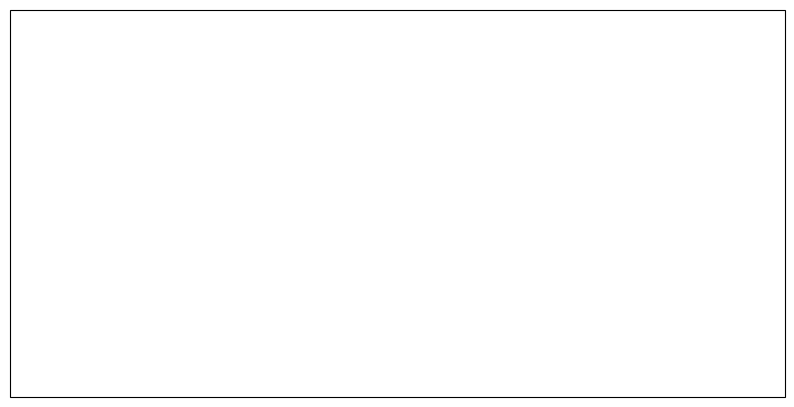

In [84]:
# Create the false onset percentage map
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Define levels for percentage (0-100%)
levels = np.arange(0, 61, 5)  # 0 to 100% in 5% increments
cmap = plt.cm.YlOrRd  # Yellow to Red colormap
norm = mcolors.BoundaryNorm(levels, cmap.N, extend='neither')

# Plot false onset percentage
im = ax.pcolormesh(false_onset_pct_kiremt.longitude, false_onset_pct_kiremt.latitude, 
                   false_onset_pct_kiremt, 
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')

# Add Ethiopia boundary
ax.add_geometries([ethiopia_geom], ccrs.PlateCarree(), 
                  facecolor='none', edgecolor='black', linewidth=1.5)
ax.coastlines(resolution='50m', linewidth=0.5)

# Set extent
ax.set_extent([33, 48, 3, 15], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.3)
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.6, aspect=20)
tick_levels = levels[::2]  # Every 10%
tick_labels = [f'{int(level)}%' for level in tick_levels]
cbar.set_ticks(tick_levels)
cbar.set_ticklabels(tick_labels)
cbar.set_label('False Onset Percentage', fontsize=12)

plt.title('False Onset Frequency (1998-2024)\nYears with Onset ≠ Wet Spell Date', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✓ False onset percentage map displayed")


---

## Part 4: Interannual Variability

Now let's analyze the interannual variability of onset dates

### Apply Masks to Onset Data

Let's focus our analysis on the Kiremt season regions within Ethiopia.

In [ ]:
Q1 = onset_doy.quantile(0.25, dim=["year"])
Q3 = onset_doy.quantile(0.75, dim=["year"])

# Calculate the IQR
iqr_value = Q3 - Q1

# Apply mask to data
iqr_masked = iqr_value.where(xr.DataArray(mask, dims=['latitude', 'longitude'], 
                                                        coords={'latitude': iqr_value.latitude, 
                                                               'longitude': iqr_value.longitude}))


In [ ]:
# Create the map for onset median day of year
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
iqr_kiremt = iqr_masked.where(jjas_mask_ethiopia)
# Define colormap levels for day of year - more refined levels
levels = np.arange(0, 51, 5)  # May 15 (135) to late September (270)

# Use a colormap similar to the paper (RdYlBu_r or similar)
# You can also try 'RdYlGn_r', 'Spectral_r', or 'coolwarm'
cmap = plt.cm.YlOrBr
norm = mcolors.BoundaryNorm(levels, cmap.N, extend='max')

# Plot discrete values at each grid point using pcolormesh
im = ax.pcolormesh(iqr_kiremt.longitude, iqr_kiremt.latitude, iqr_kiremt,
                 cmap=cmap, norm = norm, transform=ccrs.PlateCarree(), shading='auto')

# Add Ethiopia boundary
ax.add_geometries([ethiopia_geom], ccrs.PlateCarree(), 
                  facecolor='none', edgecolor='black', linewidth=1.5)

# Add other map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, alpha=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.7)

# Set map extent to Ethiopia
ax.set_extent([33, 48, 3, 15], crs=ccrs.PlateCarree())

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.1)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add colorbar with custom formatting
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.6, aspect=20)

# Create custom tick labels in MMM DD format
tick_levels = levels[::2]  # Use every other level to avoid crowding
tick_labels = tick_levels

cbar.set_ticks(tick_levels)
cbar.set_ticklabels(tick_labels)
cbar.set_label('Onset Date IQR', fontsize=12, fontweight='normal')
cbar.ax.tick_params(labelsize=10)



plt.tight_layout()
plt.show()